In [1]:
!pip install biopython
!pip install ete3

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 15.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ete3: filename=ete3-3.1.3-py3-none-any.whl size=2273786 sha256=5810ed0b8bece69294d2fd05f95bdffa237f9bf4426087aefc05502f6fee95cc
  Stored in directory: /root/.cache/pip/wheels/dd/a8/60/0a29caa9f8ceb7316704be63c1578ab13c36668abb646366ac
Successfully built ete3


# Imports

In [2]:
import os
import re
import sys
import numpy as np
import functools
import argparse
from Bio import AlignIO
from itertools import combinations
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2" 
import math
import random
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, Sequential, regularizers
import torch
from ete3 import Tree
from pandas.core.frame import DataFrame

global org_seq, comb_of_id, qp_model, qp_predict, len_of_msa, dic_for_leave_node_comb_name, start_end_list
global taxa_num, leave_node_id, leave_node_name, leave_node_comb_id, leave_node_comb_name, internal_node_name_pool

from multiprocessing import Process, Pool
import multiprocessing

import torch
from torch.utils.data import DataLoader
import torch.nn as nn

from torch.utils.data import Dataset
import random
import os
from Bio import SeqIO, Phylo
import csv
from itertools import combinations
import numpy as np
import os

2025-08-20 19:28:33.842538: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755718114.030163      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755718114.090043      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


### [Fusang] Util functions
- comb_math
- nlargest_indices
- get_quartet_ID

In [3]:
def comb_math(n,m):
    return math.factorial(n)//(math.factorial(n-m)*math.factorial(m))


def nlargest_indices(arr, n):
    uniques = np.unique(arr)
    threshold = uniques[-n]
    return np.where(arr >= threshold)


def get_quartet_ID(quartet):
    return "".join(sorted(quartet))

### [Fusang] Tree from quartet

In [4]:
def tree_from_quartet(quartet):
    root = Tree()
    root.name = "internal_node_0"
    left = root.add_child(name="internal_node_1")
    left.add_child(name=quartet[0])
    left.add_child(name=quartet[1])
    right = root.add_child(name="internal_node_2")
    right.add_child(name=quartet[2])
    right.add_child(name=quartet[3])
    for desc in root.iter_descendants():
        desc.dist = 0
    return root

### [Fusang] Getting topology ID
- Given a quartet
- Given a quartet key and 2 clusters

In [5]:
def get_topology_ID(quartet):
    return get_quartet_ID(quartet[0:2]) + get_quartet_ID(quartet[2:4])


def get_current_topology_id(quart_key, cluster_1, cluster_2):
    ans = []
    a1 = quart_key.index(cluster_1)
    a2 = quart_key.index(cluster_2)
    ans.append(str(a1))
    ans.append(str(a2))
    ans = set(ans)
    if ans == {'0', '1'} or ans == {'2', '3'}:
        return 0
    elif ans == {'0', '2'} or ans == {'1', '3'}:
        return 1
    elif ans == {'0', '3'} or ans == {'1', '2'}:
        return 2
    else:
        print('Error of function get_current_topology_id, exit the program')
        sys.exit(0)

### [Fusang] Tree Functions
- judge_tree_score
- get_modify_tree

In [6]:
def judge_tree_score(tree, quart_distribution, new_addition_taxa, dic_for_leave_node_comb_name):
    '''
        parameter
        tree: a candidate tree, can be any taxas
        quart_distribution: the prob distribution of the topology of every 4-taxa
    '''
    crt_tree = tree.copy("newick")
    leaves = crt_tree.get_leaves()

    leaves = [ele.name for ele in leaves]
    total_quarts = list(combinations(leaves, 4))
    quarts = []
    for ele in total_quarts:
        if new_addition_taxa in ele:
            quarts.append(ele)

    total_quart_score = 0

    for quart in quarts:
        crt_tree = tree.copy("newick")
        try:
            crt_tree.prune(list(quart))
        except:
            print('Error of pruning 4 taxa from current tree, the current tree is:')
            print(crt_tree)
            sys.exit(0)

        quart_key = "".join(sorted(list(quart)))
        #quart_topo_id = leave_node_comb_name.index(quart_key)

        quart_topo_id = dic_for_leave_node_comb_name[quart_key]

        quart_topo_distribution = quart_distribution[quart_topo_id]

        # judge current tree belongs to which topology
        tmp = re.findall("\([\s\S]\,[\s\S]\)", crt_tree.write(format=9))[0]
        topology_id = get_current_topology_id(quart_key, tmp[1], tmp[3])

        total_quart_score += np.log(quart_topo_distribution[topology_id]+1e-200)

    return total_quart_score


def get_modify_tree(tmp_tree, edge_0, edge_1, new_add_node_name):
    '''
        add a new leave node between edge_0 and edge_1
        default: edge_0 is the parent node of edge_1
    '''
    modify_tree = tmp_tree.copy("newick")
    if edge_0 != edge_1:
        new_node = Tree()
        new_node.add_child(name=new_add_node_name)
        detached_node = modify_tree&edge_1
        detached = detached_node.detach()
        inserted_node = modify_tree&edge_0
        inserted_node.add_child(new_node)
        new_node.add_child(detached_node)

    else:
        modify_tree.add_child(name=new_add_node_name)

    return modify_tree


### [Fusang] Search branch function

In [7]:
def search_this_branch(tmp_tree, edge_0, edge_1, current_quartets, current_leave_node_name, queue, dic_for_leave_node_comb_name):
    modify_tree = get_modify_tree(tmp_tree, edge_0, edge_1, current_leave_node_name)
    modify_tree.resolve_polytomy(recursive=True)
    modify_tree.unroot()
    tmp_tree_score = judge_tree_score(modify_tree, current_quartets, current_leave_node_name, dic_for_leave_node_comb_name)

    dic = {}
    dic['tree'] = modify_tree
    dic['score'] = tmp_tree_score
    queue.put(dic)

### [Fusang] Mask Functions

In [8]:
def select_mask_node_pair(qp_predict, new_add_taxa):
    
    if new_add_taxa <= 9:
        return None

    mask_node_pair = []
    
    current_start = start_end_list[new_add_taxa][0]
    current_end = start_end_list[new_add_taxa][1]
    select_distribution = qp_predict[current_start:current_end+1]
    if np.max(select_distribution) < 0.90:
        return None
    else:
        x,y = nlargest_indices(select_distribution, int(max(10,0.01*len(select_distribution)))) 
        
    for i in range(0,len(x)):
        idx = x[i]
        topology_value = y[i]
        quartet_comb = comb_of_id[current_start+idx]
        
        if topology_value == 0:
            mask_node_pair.append((quartet_comb[0],quartet_comb[1]))
        if topology_value == 1:
            mask_node_pair.append((quartet_comb[0],quartet_comb[2]))
        if topology_value == 2:
            mask_node_pair.append((quartet_comb[1],quartet_comb[2]))
            
    return mask_node_pair


def mask_edge(tree,node1,node2,edge_list):
    # mask edge between node1 and node2

    if len(edge_list) <= 3:
        return edge_list

    ancestor_name = tree.get_common_ancestor(node1,node2).name
    remove_edge = []

    node = tree.search_nodes(name=node1)[0]
    while node:
        if node.name == ancestor_name:
            break

        edge_0 = node.up.name
        edge_1 = node.name

        if len(remove_edge) >= len(edge_list) - 3:
            break
        remove_edge.append((edge_0, edge_1))
        node = node.up

    node = tree.search_nodes(name=node2)[0]
    while node:
        if node.name == ancestor_name:
            break

        edge_0 = node.up.name
        edge_1 = node.name

        if len(remove_edge) >= len(edge_list) - 3:
            break
        remove_edge.append((edge_0, edge_1))
        node = node.up

    for ele in remove_edge:
        if ele in edge_list:
            edge_list.remove(ele)

    return edge_list

### [Fusang] Gen_phylogen_tree
search phylo tree having highest score

In [9]:
def gen_phylogenetic_tree(current_quartets, beam_size):
    '''
        search the phylogenetic tree having highest score
        idx: the name of numpy file 
    '''
    current_leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
    
    candidate_tree_beam = []

    quartet_id = leave_node_comb_name[0]

    for _label in [0, 1, 2]:
        if _label == 0:
            label_id = "".join([quartet_id[0], quartet_id[1], quartet_id[2], quartet_id[3]])
        elif _label == 1:
            label_id = "".join([quartet_id[0], quartet_id[2], quartet_id[1], quartet_id[3]])
        elif _label == 2:
            label_id = "".join([quartet_id[0], quartet_id[3], quartet_id[1], quartet_id[2]])
        
        _tree = tree_from_quartet(label_id)
        _tree.unroot()

        _tree_score = current_quartets[0, _label]

        tmp_tree_dict = {'Tree':_tree, 'tree_score':_tree_score}
        candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])

    idx_for_internal_node_name_pool = 0

    current_tree_score_beam = []
    optim_tree_beam = []

    #in the start point set beam size equal to 3
    for i in range(0, 3):
        current_tree_score_beam.append(candidate_tree_beam[i]['tree_score'])
        optim_tree_beam.append(candidate_tree_beam[i]['Tree'])
    
    for i in range(4, len(current_leave_node_name)):
        candidate_tree_beam = []

        for j in range(0, len(optim_tree_beam)):
            ele = optim_tree_beam[j]

            idx_for_this_iter = 0

            edge_0_list = []
            edge_1_list = []

            if ele == None:
                continue
            optim_tree = ele.copy("newick")

            for node in optim_tree.iter_descendants():
                tmp_tree = optim_tree.copy("newick")
                edge_0 = node.up.name
                edge_1 = node.name
                if edge_0 == '' or edge_1 == '':
                    continue

                else:
                    edge_0_list.append(edge_0)
                    edge_1_list.append(edge_1)

            queue = multiprocessing.Manager().Queue()
            para_list = [(tmp_tree, edge_0_list[k], edge_1_list[k], current_quartets, current_leave_node_name[i], queue, dic_for_leave_node_comb_name) for k in range(0, len(edge_0_list))]

            process_num = min(64, 2*i+6)
            pool = Pool(process_num)
            pool.starmap(search_this_branch, para_list)
            pool.close()
            pool.join()

            candidate_tree_score = []
            candidate_tree = []

            while not queue.empty():
                tmp_dic = queue.get()
                
                tmp_tree_dict = {'Tree':tmp_dic['tree'], 'tree_score':tmp_dic['score']+current_tree_score_beam[j]}
                candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])
        candidate_tree_beam = candidate_tree_beam[0:beam_size]
        
        optim_tree_beam = []
        current_tree_score_beam = []
        for ele in candidate_tree_beam:
            crt_tree = ele['Tree'].copy("newick") 
            for node in crt_tree.traverse("preorder"):
                if node.name == '':
                    node.name = str(internal_node_name_pool[idx_for_internal_node_name_pool])
                    idx_for_internal_node_name_pool += 1
            optim_tree_beam.append(crt_tree)
            crt_tree_score = ele['tree_score']
            current_tree_score_beam.append(crt_tree_score)
            
    return optim_tree_beam[0].write(format=9)


def gen_phylogenetic_tree_2(current_quartets, beam_size):
    '''
        search the phylogenetic tree having highest score
        idx: the name of numpy file 
    '''
    current_leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
    
    candidate_tree_beam = []

    quartet_id = leave_node_comb_name[0]

    for _label in [0, 1, 2]:
        if _label == 0:
            label_id = "".join([quartet_id[0], quartet_id[1], quartet_id[2], quartet_id[3]])
        elif _label == 1:
            label_id = "".join([quartet_id[0], quartet_id[2], quartet_id[1], quartet_id[3]])
        elif _label == 2:
            label_id = "".join([quartet_id[0], quartet_id[3], quartet_id[1], quartet_id[2]])
        
        _tree = tree_from_quartet(label_id)
        _tree.unroot()

        _tree_score = current_quartets[0, _label]

        tmp_tree_dict = {'Tree':_tree, 'tree_score':_tree_score}
        candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])

    idx_for_internal_node_name_pool = 0

    current_tree_score_beam = []
    optim_tree_beam = []

    #in the start point set beam size equal to 3
    for i in range(0, 3):
        current_tree_score_beam.append(candidate_tree_beam[i]['tree_score'])
        optim_tree_beam.append(candidate_tree_beam[i]['Tree'])
    
    for i in range(4, len(current_leave_node_name)):
        candidate_tree_beam = []

        for j in range(0, len(optim_tree_beam)):
            ele = optim_tree_beam[j]

            idx_for_this_iter = 0

            edge_0_list = []
            edge_1_list = []

            if ele == None:
                continue
            optim_tree = ele.copy("newick")

            for node in optim_tree.iter_descendants():
                tmp_tree = optim_tree.copy("newick")
                edge_0 = node.up.name
                edge_1 = node.name
                if edge_0 == '' or edge_1 == '':
                    continue

                else:
                    edge_0_list.append(edge_0)
                    edge_1_list.append(edge_1)

            edge_list = [(edge_0_list[i], edge_1_list[i]) for i in range(0, len(edge_0_list))]
            mask_node_pairs = select_mask_node_pair(current_quartets, i)

            if mask_node_pairs != None:

                mask_node_pairs = list(set(mask_node_pairs))
                for node_pairs in mask_node_pairs:
                    node1 = chr(ord(u'\u4e00')+node_pairs[0])
                    node2 = chr(ord(u'\u4e00')+node_pairs[1])
                    
                    edge_list = mask_edge(ele.copy("deepcopy"),node1,node2,edge_list)
                    if len(edge_list) <= 3:
                        break

            edge_0_list = [ele[0] for ele in edge_list]
            edge_1_list = [ele[1] for ele in edge_list]

            queue = multiprocessing.Manager().Queue()
            para_list = [(tmp_tree, edge_0_list[k], edge_1_list[k], current_quartets, current_leave_node_name[i], queue, dic_for_leave_node_comb_name) for k in range(0, len(edge_0_list))]

            process_num = min(64, len(edge_0_list))
            pool = Pool(process_num)
            pool.starmap(search_this_branch, para_list)
            pool.close()
            pool.join()

            candidate_tree_score = []
            candidate_tree = []

            while not queue.empty():
                tmp_dic = queue.get()
                
                tmp_tree_dict = {'Tree':tmp_dic['tree'], 'tree_score':tmp_dic['score']+current_tree_score_beam[j]}
                candidate_tree_beam.append(tmp_tree_dict)

        candidate_tree_beam.sort(key=lambda k: -k['tree_score'])
        candidate_tree_beam = candidate_tree_beam[0:beam_size]
        
        optim_tree_beam = []
        current_tree_score_beam = []
        for ele in candidate_tree_beam:
            crt_tree = ele['Tree'].copy("newick") 
            for node in crt_tree.traverse("preorder"):
                if node.name == '':
                    node.name = str(internal_node_name_pool[idx_for_internal_node_name_pool])
                    idx_for_internal_node_name_pool += 1
            optim_tree_beam.append(crt_tree)
            crt_tree_score = ele['tree_score']
            current_tree_score_beam.append(crt_tree_score)

    return optim_tree_beam[0].write(format=9)

### [Fusang] Util functions
- transform_str
- cmp
- get_numpy

In [10]:
def transform_str(str_a, taxa_name):
    str_b = ''
    id_set = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]

    for i in range(0, len(str_a)):
        if str_a[i] in id_set:
            str_b += taxa_name[ord(str_a[i])-ord(u'\u4e00')]
        else:
            str_b += str_a[i]

    return str_b


def cmp(a, b):
    if int(b) > int(a):
        return -1
    if int(a) < int(b):
        return 1
    return 0


def get_numpy(aln_file):
    '''
        current version only supports the total length of msa less than 10K
    '''
    aln = open(aln_file)
    dic = {'A':'0','T':'1','C':'2','G':'3','-':'4', 'N':'4'}

    # for masking other unknown bases
    other_base = ['R', 'Y', 'K', 'M', 'U', 'S', 'W', 'B', 'D', 'H', 'V', 'X']
    for ele in other_base:
        dic[ele] = '4'

    matrix_out=[]
    fasta_dic={}
    for line in aln:
        if line[0]==">":
            header=line[1:].rstrip('\n').strip()
            fasta_dic[header]=[]
        elif line[0].isalpha() or line[0]=='-':
            for base, num in dic.items():
                line=line[:].rstrip('\n').strip().replace(base,num)
            line=list(line)
            line=[int(n) for n in line]
            fasta_dic[header] += line+[4]*(14000-len(line))

    taxa_block=[]
    for taxa in sorted(list(fasta_dic.keys()), key=functools.cmp_to_key(cmp)):
        taxa_block.append(fasta_dic[taxa.strip()])
    fasta_dic={}
    matrix_out.append(taxa_block)

    return np.array(matrix_out)

### [QPhyloformer] Defining QP models for different lenghts (>1200 or >240)

In [11]:
class RowAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)

    def forward(self, x):
        # x: (B, N=4, L, D)
        B, N, L, D = x.shape
        x = x.transpose(1, 2)         # (B, L, N, D)
        x = x.reshape(B * L, N, D)
        x, _ = self.attn(x, x, x)
        x = x.reshape(B, L, N, D).transpose(1, 2)  # (B, N, L, D)
        return x

In [12]:
class ColumnAttention(nn.Module):
    def __init__(self, dim, heads):
        super().__init__()
        self.attn = nn.MultiheadAttention(dim, heads, batch_first=True)

    def forward(self, x):
        # x: (B, N=4, L, D)
        B, N, L, D = x.shape
        x = x.reshape(B * N, L, D)
        x, _ = self.attn(x, x, x)
        x = x.reshape(B, N, L, D)
        return x

In [13]:
class MSABlock(nn.Module):
    def __init__(self, dim, heads, dropout=0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.norm2 = nn.LayerNorm(dim)
        self.norm3 = nn.LayerNorm(dim)

        self.row_attn = RowAttention(dim, heads)
        self.col_attn = ColumnAttention(dim, heads)

        self.ffn = nn.Sequential(
            nn.Linear(dim, dim * 4),
            nn.GELU(),
            nn.Linear(dim * 4, dim), # 
            nn.Dropout(dropout)
        )
    def forward(self, x):
        # Row Attention + residual
        x = x + self.row_attn(self.norm1(x))
        # Column Attention + residual
        x = x + self.col_attn(self.norm2(x))
        # Feed‑Forward + residual
        x = x + self.ffn(self.norm3(x))
        return x

In [14]:
class QPhyloformer(nn.Module):
    def __init__(self, dim=64, heads=4, layers_num=4):
        super().__init__()
        self.embedding = nn.Embedding(VOCAB_SIZE, dim)
        self.taxon_embed = nn.Embedding(4, dim)  # 4 fixed taxa
        self.blocks = nn.ModuleList([
            MSABlock(dim, heads) for _ in range(layers_num)
        ])
        self.norm = nn.LayerNorm(dim)

        # (B, D, 4, L)
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((1, 1)),  # pool over taxa × sites -> (B, D, 1, 1)
            nn.Flatten(), # (B, D)
            nn.Linear(dim, 3),  # (B, 3)
            nn.Softmax(dim=1)
            # nn.Flatten(),               # (B, D, 4, L) -> (B, D*4*L)
            # nn.Linear(dim * 4 * seq_len, 3), # fixed input size
            # nn.Softmax(dim=1)
        )

    def forward(self, x):
        # x: (B, 4, L), each entry ∈ [0, VOCAB_SIZE-1]
        if isinstance(x, np.ndarray):
            x = torch.from_numpy(x)
        x = x.long()
        # print(f"Input shape: {x.shape}")
        B, N, L = x.shape
        x = self.embedding(x)  # (B, 4, L, D)
        taxon_ids = torch.arange(N, device=x.device).unsqueeze(0).expand(B, N)
        taxon_embed = self.taxon_embed(taxon_ids).unsqueeze(2)  # (B, 4, 1, D)
        x = x + taxon_embed  # (B, 4, L, D)

        for block in self.blocks:
            x = block(x)

        x = self.norm(x)

        x = x.permute(0, 3, 1, 2)  # (B, D, 4, L) -> Quick Fix. Need to recheck.
        prediction = self.classifier(x)  # (B, 3)
        return prediction
    
    def load_weights(self, filepath):
        self.load_state_dict(torch.load(filepath, map_location=torch.device('cpu')))
        self.to(torch.device('cpu'))

In [15]:
def get_qp_model(seq_len=512, dim=64, heads=4, layers_num=4):
    return QPhyloformer(dim=dim, heads=heads, layers_num=layers_num)

### [Fusang] Predict Functions (slide_window)

In [16]:
def fill_qp_predict_each_slide_window(len_idx_1, len_idx_2):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 1200))

        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]

        test_seq = torch.from_numpy(batch_seq).long()
        predicted = qp_model(x=test_seq)

        for j in range(0, len(batch_seq)):
            qp_predict[i*50000+j,:] += predicted[j,:]
        #qp_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 1200))

    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]

    test_seq = torch.from_numpy(batch_seq).long()
    predicted = qp_model(x=test_seq)

    for j in range(0, len(batch_seq)):
        qp_predict[iters*50000+j,:] += predicted[j,:]
    #qp_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]
    
def fill_qp_predict_each_slide_window_2(len_idx_1, len_idx_2):
    start_pos = 0
    iters = len(comb_of_id) // 50000
    for i in range(0, iters):
        batch_seq = np.zeros((50000, 4, 240))
        for j in range(0, len(batch_seq)):
            idx = np.array(comb_of_id[i*50000+j])
            batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]
        
        # test_seq = tf.expand_dims(batch_seq.astype(np.float32), axis=-1)
        test_seq = torch.from_numpy(batch_seq).long()  # shape: (50000, 4, 240)
        predicted = qp_model(x=test_seq)

        for j in range(0, len(batch_seq)):
            qp_predict[i*50000+j,:] += predicted[j,:]
        #qp_predict[i*50000:i*50000+len(batch_seq),:] += predicted[:,:]

        start_pos += 50000

    last_batch_size = len(comb_of_id) % 50000
    batch_seq = np.zeros((last_batch_size, 4, 240))

    for j in range(0, len(batch_seq)):
        idx = np.array(comb_of_id[iters*50000+j])
        batch_seq[j] = org_seq[0, idx[:], len_idx_1:len_idx_2]

    test_seq = torch.from_numpy(batch_seq).long()
    predicted = qp_model(x=test_seq)

    for j in range(0, len(batch_seq)):
        qp_predict[iters*50000+j,:] += predicted[j,:]
    #qp_predict[iters*50000:iters*50000+len(batch_seq),:] += predicted[:,:]

def fill_qp_predict(window_number):
    step = (len_of_msa - 1200) // window_number
    start_idx = 0
    for i in range(0, window_number):
        end_idx = start_idx + 1200
        fill_qp_predict_each_slide_window(start_idx, end_idx)
        start_idx += step
        
def fill_qp_predict_2(window_number):
    if len_of_msa > 240:
        step = (len_of_msa - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            fill_qp_predict_each_slide_window_2(start_idx, end_idx)
            start_idx += step

    else:
        step = (250 - 240) // window_number
        start_idx = 0
        for i in range(0, window_number):
            end_idx = start_idx + 240
            fill_qp_predict_each_slide_window_2(start_idx, end_idx)
            start_idx += step

### [QPhyloformer] Training

In [17]:
def derive_quartets_from_full_msa(msa_folder, label_folder, msa_format='fasta'):
    """
    Reads a folder of MSA files and a CSV file with labels, then derives quartets and their labels.
    msa_folder: path to folder containing MSA files (.npy)
    label_folder: path to folder containing label files (.npy)
    Returns: list of (encoded_quartet, quartet_label)
    """
    quartet_data = []

    msa_files = sorted(os.listdir(msa_folder))
    label_files = sorted(os.listdir(label_folder))

    print(f"[Data] Found {len(msa_files)} MSA files and {len(label_files)} label files")

    # wrap with tqdm
    for seq_file, label_file in tqdm(zip(msa_files, label_files),
                                     total=min(len(msa_files), len(label_files)),
                                     desc="Loading Quartets"):
        label_path = os.path.join(label_folder, label_file)
        label = np.load(label_path, allow_pickle=True)

        seq_path = os.path.join(msa_folder, seq_file)
        seq = np.load(seq_path, allow_pickle=True).squeeze(axis=0)

        quartet_data.append((seq, label))

    return quartet_data

In [18]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    total_loss, correct = 0, 0

    for x, y in dataloader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()

    return total_loss / len(dataloader.dataset), correct / len(dataloader.dataset)


class QuartetDataset(Dataset):
    def __init__(self, quartet_data):
        self.data = quartet_data
    def __getitem__(self, idx):
        return self.data[idx]
    def __len__(self):
        return len(self.data)

[Data] Found 10000 MSA files and 10000 label files


Loading Quartets: 100%|██████████| 10000/10000 [03:12<00:00, 52.01it/s]


Epoch 1: Train Loss=1.1006, Acc=0.3343 | Val Loss=1.1018, Acc=0.3187
Epoch 2: Train Loss=1.0981, Acc=0.3404 | Val Loss=1.0994, Acc=0.3527
Epoch 3: Train Loss=1.0479, Acc=0.4614 | Val Loss=0.9582, Acc=0.5660
Epoch 4: Train Loss=0.7894, Acc=0.7696 | Val Loss=0.7679, Acc=0.7740
Epoch 5: Train Loss=0.7381, Acc=0.8069 | Val Loss=0.7360, Acc=0.8020
Epoch 6: Train Loss=0.7256, Acc=0.8203 | Val Loss=0.7165, Acc=0.8307
Epoch 7: Train Loss=0.7159, Acc=0.8331 | Val Loss=0.7205, Acc=0.8247
Epoch 8: Train Loss=0.7138, Acc=0.8316 | Val Loss=0.7065, Acc=0.8387
Epoch 9: Train Loss=0.7031, Acc=0.8419 | Val Loss=0.7057, Acc=0.8380
Epoch 10: Train Loss=0.6981, Acc=0.8461 | Val Loss=0.7208, Acc=0.8240
Epoch 11: Train Loss=0.6992, Acc=0.8467 | Val Loss=0.7199, Acc=0.8280
Epoch 12: Train Loss=0.6967, Acc=0.8491 | Val Loss=0.7118, Acc=0.8340
Epoch 13: Train Loss=0.6943, Acc=0.8531 | Val Loss=0.6957, Acc=0.8480
Epoch 14: Train Loss=0.6896, Acc=0.8586 | Val Loss=0.6969, Acc=0.8507
Epoch 15: Train Loss=0.6900, 

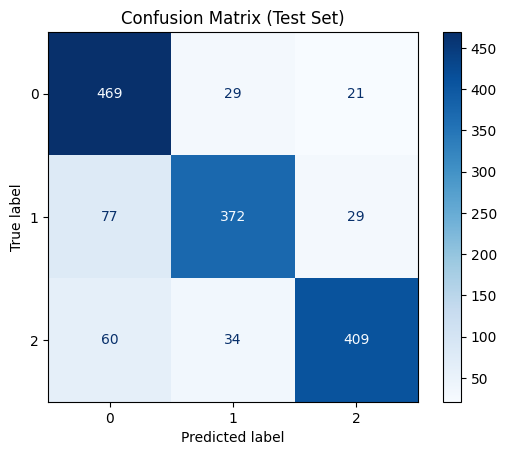

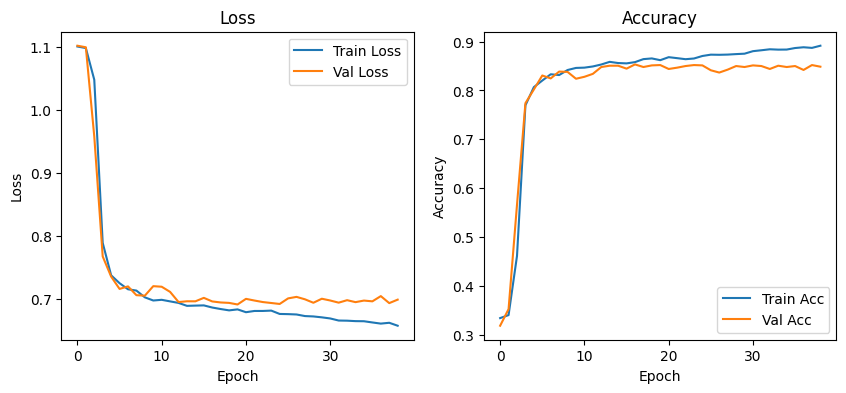

In [19]:
BASE2IDX = {'A': 0, 'C': 1, 'G': 2, 'T': 3, '-': 4, 'N': 5}
VOCAB_SIZE = len(BASE2IDX)
from tqdm import tqdm
from torch.utils.data import random_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = QPhyloformer().to(device)

quartet_data = derive_quartets_from_full_msa(
    '/kaggle/input/fusang/S2G/numpy_file/seq', 
    '/kaggle/input/fusang/S2G/numpy_file/label'
)

total_size = len(quartet_data)
train_size = int(0.7 * total_size)
val_size   = int(0.15 * total_size)
test_size  = total_size - train_size - val_size

train_data, val_data, test_data = random_split(
    quartet_data, [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)

train_ds = QuartetDataset(train_data)
val_ds   = QuartetDataset(val_data)
test_ds  = QuartetDataset(test_data)

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader   = DataLoader(val_ds, batch_size=32)
test_loader  = DataLoader(test_ds, batch_size=32)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.CrossEntropyLoss()

history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}

for epoch in range(1, 40):
    # --- training loop ---
    model.train()
    total_loss, correct = 0, 0
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()

    train_loss = total_loss / len(train_loader.dataset)
    train_acc = correct / len(train_loader.dataset)

    # --- validation loop ---
    model.eval()
    total_loss, correct = 0, 0
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = criterion(logits, y)
            total_loss += loss.item() * x.size(0)
            correct += (logits.argmax(dim=1) == y).sum().item()

    val_loss = total_loss / len(val_loader.dataset)
    val_acc = correct / len(val_loader.dataset)

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Acc={train_acc:.4f} | "
          f"Val Loss={val_loss:.4f}, Acc={val_acc:.4f}")

# --- test evaluation + confusion matrix ---
model.eval()
total_loss, correct = 0, 0
all_preds, all_labels = [], []
with torch.no_grad():
    for x, y in test_loader:
        x, y = x.to(device), y.to(device)
        logits = model(x)
        loss = criterion(logits, y)

        total_loss += loss.item() * x.size(0)
        correct += (logits.argmax(dim=1) == y).sum().item()

        all_preds.extend(logits.argmax(dim=1).cpu().numpy())
        all_labels.extend(y.cpu().numpy())

test_loss = total_loss / len(test_loader.dataset)
test_acc = correct / len(test_loader.dataset)
print(f"\nFinal Test Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# --- confusion matrix ---
cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix (Test Set)")
plt.show()

# --- plots for training curves ---
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Loss")

plt.subplot(1,2,2)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Accuracy")

plt.show()

In [20]:
torch.save(model.state_dict(), "S2G.pt")
print("Model weights saved.")

Model weights saved.


### [Fusang] MSA -> Tree (Inference)

In [21]:
# if __name__ == '__main__':
# parser = argparse.ArgumentParser('get_msa_dir')
# p_input = parser.add_argument_group("INPUT")
# p_input.add_argument("--msa_dir", action="store", type=str, required=True)
# p_input.add_argument("--save_prefix", action="store", type=str, required=True)
# p_input.add_argument("--beam_size", action="store", type=str, default='1', required=False)
# p_input.add_argument("--sequence_type", action="store", type=str, default='standard', required=False)
# p_input.add_argument("--branch_model", action="store", type=str, default='gamma', required=False)
# p_input.add_argument("--window_coverage", action="store", type=str, default='1', required=False)
# p_input.add_argument("--verbose", action="store_true", help="Enable verbose output.")
# args = parser.parse_args()
# msa_dir = args.msa_dir
# save_prefix = args.save_prefix
# beam_size = args.beam_size
# sequence_type = args.sequence_type
# branch_model = args.branch_model
# window_coverage = args.window_coverage
# verbose = args.verbose

msa_dir = "/kaggle/input/sample-msa/a.fas"
save_prefix = "tree_for_a"
beam_size = '1'
sequence_type = 'standard'
branch_model = 'gamma'
window_coverage = '1'
verbose = True


def vprint(*a, **kw):
    if verbose:
        print(*a, **kw)

vprint("[QPhyloformer] Starting workflow with arguments:")
vprint(f"  msa_dir: {msa_dir}")
vprint(f"  save_prefix: {save_prefix}")
vprint(f"  beam_size: {beam_size}")
vprint(f"  sequence_type: {sequence_type}")
vprint(f"  branch_model: {branch_model}")
vprint(f"  window_coverage: {window_coverage}")

flag = 0
support_format = ['.fas', '.phy', '.fasta', 'phylip']
bio_format = ['fasta', 'phylip', 'fasta', 'phylip']

taxa_name = {}

for i in range(0, len(support_format)):
    ele = support_format[i]
    if msa_dir.endswith(ele):
        flag = 1
        try:
            vprint(f"[QPhyloformer] Reading alignment file: {msa_dir} as {bio_format[i]}")
            alignment = AlignIO.read(open(msa_dir), bio_format[i])

            len_of_msa = len(alignment[0].seq)
            taxa_num = len(alignment)
            vprint(f"[QPhyloformer] Alignment loaded. Number of taxa: {taxa_num}, MSA length: {len_of_msa}")

            save_alignment = save_prefix + '_fusang.fas'
            with open(save_alignment,'w') as f:
                for record in alignment:
                    taxa_name[len(taxa_name)] = record.id
                    f.write('>'+str(len(taxa_name)-1)+'\n')
                    f.write(str(record.seq)+'\n')
            vprint(f"[QPhyloformer] Alignment saved to: {save_alignment}")
        except Exception as e:
            print('Something wrong about your msa file, please check your msa file')
            if verbose:
                print(f"[QPhyloformer] Exception: {e}")
        break

if flag == 0:
    print('we do not support this format of msa')
    sys.exit(1)

start_end_list = [None, None, None]

end = -1
for i in range(3, 100):
    start = end + 1
    end = start + int(comb_math(i,3)) - 1
    start_end_list.append((start,end))

id_for_taxa = [i for i in range(0, taxa_num)]
comb_of_id = list(combinations(id_for_taxa, 4))
comb_of_id.sort(key=lambda ele: ele[-1])

leave_node_id = [i for i in range(0, taxa_num)]
leave_node_name = [chr(ord(u'\u4e00')+i) for i in range(0, taxa_num)]
leave_node_comb_id = comb_of_id

leave_node_comb_name = []

dic_for_leave_node_comb_name = {}

for ele in leave_node_comb_id:
    term = [chr(ord(u'\u4e00')+id) for id in ele]
    dic_for_leave_node_comb_name["".join(term)] = len(dic_for_leave_node_comb_name)
    leave_node_comb_name.append("".join(term))

internal_node_name_pool = ['internal_node_' + str(i) for i in range(3, 3000)]

fusang_msa_dir = save_prefix + '_fusang.fas'
vprint(f"[QPhyloformer] Converting alignment to numpy array...")
org_seq = get_numpy(fusang_msa_dir)
os.remove(fusang_msa_dir)
vprint(f"[QPhyloformer] Alignment numpy array created and temp file removed.")

window_number = 1

if len_of_msa <= 1210:
    qp_model = get_qp_model(seq_len=240, dim=64, heads=4, layers_num=4)
    vprint("[QPhyloformer] Loading weights: /kaggle/working/S1G.pt")
    qp_model.load_weights(filepath='/kaggle/working/S1G.pt')
    window_number = int(len_of_msa * float(window_coverage) // 240 + 1) 
    vprint(f"[QPhyloformer] Window number set to {window_number}")
elif len_of_msa > 1210:
    qp_model = get_qp_model(seq_len=1200, dim=64, heads=4, layers_num=4)
    vprint("[QPhyloformer] Loading weights: /kaggle/working/S2G.pt")
    qp_model.load_weights(filepath='/kaggle/working/S2G.pt')
    window_number = int(len_of_msa * float(window_coverage) // 1200 + 1) 
    vprint(f"[QPhyloformer] Window number set to {window_number}")

vprint(f"[QPhyloformer] Filling QP predictions...")

qp_predict = torch.zeros((len(comb_of_id), 3), dtype=torch.float32)

if len_of_msa <= 1210:
    fill_qp_predict(window_number)
    qp_predict /= window_number
elif len_of_msa > 1210:
    fill_qp_predict_2(window_number)
    qp_predict /= window_number
else:
    print('current version of qphyloformer do not support this length of MSA')
    sys.exit(1)

vprint(f"[QPhyloformer] QP predictions normalized by window number.")

if not os.path.exists('./qp_output/'):
    vprint(f"[QPhyloformer] Creating output directory ./qp_output/")
    os.mkdir('./qp_output/')

vprint(f"[QPhyloformer] Searching for best phylogenetic tree...")

# Print the quartets in qp_predict

qp_predict_np = qp_predict.detach().cpu().numpy()
if taxa_num > 10:
    searched_tree = transform_str(gen_phylogenetic_tree_2(qp_predict_np, int(beam_size)), taxa_name)
else:
    searched_tree = transform_str(gen_phylogenetic_tree(qp_predict_np, int(beam_size)), taxa_name)
vprint(f"[QPhyloformer] Tree search complete.")

build_log = open('./qp_output/{}.txt'.format(save_prefix), 'a')
build_log.write(searched_tree)
build_log.close()
vprint(f"[QPhyloformer] Tree written to ./qp_output/{save_prefix}.txt")

[QPhyloformer] Starting workflow with arguments:
  msa_dir: /kaggle/input/sample-msa/a.fas
  save_prefix: tree_for_a
  beam_size: 1
  sequence_type: standard
  branch_model: gamma
  window_coverage: 1
[QPhyloformer] Reading alignment file: /kaggle/input/sample-msa/a.fas as fasta
[QPhyloformer] Alignment loaded. Number of taxa: 8, MSA length: 1337
[QPhyloformer] Alignment saved to: tree_for_a_fusang.fas
[QPhyloformer] Converting alignment to numpy array...
[QPhyloformer] Alignment numpy array created and temp file removed.
[QPhyloformer] Loading weights: /kaggle/working/S2G.pt
[QPhyloformer] Window number set to 2
[QPhyloformer] Filling QP predictions...
[QPhyloformer] QP predictions normalized by window number.
[QPhyloformer] Creating output directory ./qp_output/
[QPhyloformer] Searching for best phylogenetic tree...
[QPhyloformer] Tree search complete.
[QPhyloformer] Tree written to ./qp_output/tree_for_a.txt
